# Tuning hyper parameters 

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [32]:
from demand_forecasting.read import read_data

# reading voiholm rode data 
rides_raw_df = read_data('../input/voiholm.csv')

# reading weather data
weather_raw_df = read_data('../input/weather_data.csv')

INFO:root:Read dataframe from file path ../input/voiholm.csv
INFO:root:Read dataframe from file path ../input/weather_data.csv


In [33]:
from demand_forecasting.verify import verify_ride_df, verify_weather_df

# verifying the dataframes 
rides_df = verify_ride_df(rides_raw_df)
weather_df = verify_weather_df(weather_raw_df)

INFO:root:Validated Voiholm ride dataframe
INFO:root:Validated weather dataframe


In [34]:
from demand_forecasting.preprocess import preprocessing

df, unique_h3index_df = preprocessing(rides_df=rides_df, weather_df=weather_df)
df

INFO:root:Preprossed dataframe


,h3index_small,start_date,num_of_rides,date,temperature,max_temperature,min_temperature,precipitation,start_weekday
0,891f2506107ffff,2020-08-01,0.0,2020-08-01,17.6,19.3,15.6,0.69,Saturday
1,891f2506107ffff,2020-08-02,0.0,2020-08-02,16.7,19.1,14.8,0.00,Sunday
2,891f2506107ffff,2020-08-03,1.0,2020-08-03,16.8,19.6,14.3,0.00,Monday
3,891f2506107ffff,2020-08-04,2.0,2020-08-04,15.0,17.1,12.8,11.44,Tuesday
4,891f2506107ffff,2020-08-05,2.0,2020-08-05,21.5,26.5,17.0,0.50,Wednesday
...,...,...,...,...,...,...,...,...,...
9775,891f25a9ecbffff,2020-08-26,0.0,2020-08-26,16.7,20.8,13.5,0.00,Wednesday
9776,891f25a9ecbffff,2020-08-27,0.0,2020-08-27,13.9,18.5,9.1,0.60,Thursday
9777,891f25a9ecbffff,2020-08-28,0.0,2020-08-28,14.5,17.8,12.1,0.10,Friday
9778,891f25a9ecbffff,2020-08-29,1.0,2020-08-29,14.7,19.8,8.9,0.00,Saturday


In [35]:
from demand_forecasting.features import generate_features

df_with_features = generate_features(df)
df_with_features

INFO:root:Generated features for training dataset


,h3index_small,start_date,num_of_rides,date,temperature,max_temperature,min_temperature,precipitation,start_weekday,avg_num_rides_in_area_one_week_before
0,891f2506107ffff,2020-08-01,0.0,2020-08-01,17.6,19.3,15.6,0.69,Saturday,NaN
1,891f2506107ffff,2020-08-02,0.0,2020-08-02,16.7,19.1,14.8,0.00,Sunday,NaN
2,891f2506107ffff,2020-08-03,1.0,2020-08-03,16.8,19.6,14.3,0.00,Monday,NaN
3,891f2506107ffff,2020-08-04,2.0,2020-08-04,15.0,17.1,12.8,11.44,Tuesday,NaN
4,891f2506107ffff,2020-08-05,2.0,2020-08-05,21.5,26.5,17.0,0.50,Wednesday,NaN
...,...,...,...,...,...,...,...,...,...,...
9775,891f25a9ecbffff,2020-08-26,0.0,2020-08-26,16.7,20.8,13.5,0.00,Wednesday,0.285714
9776,891f25a9ecbffff,2020-08-27,0.0,2020-08-27,13.9,18.5,9.1,0.60,Thursday,0.285714
9777,891f25a9ecbffff,2020-08-28,0.0,2020-08-28,14.5,17.8,12.1,0.10,Friday,0.285714
9778,891f25a9ecbffff,2020-08-29,1.0,2020-08-29,14.7,19.8,8.9,0.00,Saturday,0.142857


### Hyper parameter tuning 

In [45]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

In [46]:
from app import config

target_variable = config.MODEL_CONFIG['target']
features = config.MODEL_CONFIG['features']
features

['precipitation',
 'start_weekday',
 'max_temperature',
 'avg_num_rides_in_area_one_week_before']

In [47]:
all_feature_df = df_with_features[df_with_features.avg_num_rides_in_area_one_week_before.notna()]

columns = features.copy()
columns.append(target_variable)
model_df = all_feature_df[columns].copy()

model_df['start_weekday'] = model_df.start_weekday.astype("category")

# Setting a side evaluation data to not be used when training and hyper parameter tuning the model
training_df, evaluation_df = train_test_split(model_df, test_size=0.15, random_state=43)

X = training_df.drop(columns=target_variable)
y = training_df[[target_variable]]
X

,precipitation,start_weekday,max_temperature,avg_num_rides_in_area_one_week_before
9351,0.20,Saturday,20.5,2.285714
6479,0.00,Sunday,19.0,0.142857
3651,0.20,Saturday,20.5,6.428571
2358,1.19,Wednesday,24.3,14.428571
885,0.00,Sunday,30.6,9.000000
...,...,...,...,...
8092,0.00,Sunday,18.6,2.714286
3039,0.00,Monday,26.3,9.428571
3010,0.00,Tuesday,26.1,6.428571
4428,1.19,Wednesday,24.3,5.571429


In [48]:
from sklearn.metrics import mean_absolute_error

# Deciding which hyperparameters to tune 
max_depths = [2, 3, 4, 5, 6]
learning_rates = [0.01, 0.05, 0.10, 0.15]
n_estimators = [50, 100, 200, 300, 400]

result = []
for max_depth in max_depths: 
    for learning_rate in learning_rates:
        for n_estimator in n_estimators:
            # Defining the model
            xgb_model = xgb.XGBRegressor(enable_categorical=True,
                                         max_depth=max_depth,
                                         learning_rate=learning_rate,
                                         n_estimators=n_estimator,
                                         objective='reg:squarederror', 
                                         #eval_metric=mean_absolute_error,
                                         booster='gbtree')

            # Defining model evaluation method
            cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
            scores = cross_val_score(xgb_model, X, y, cv=cv, n_jobs=-1)
            mean_score = scores.mean()
            result.append([max_depth, learning_rate, n_estimator, mean_score])

hyper_parameter_result_df = pd.DataFrame(result, columns=['max_depth', 'learning_rate', 'n_estimator', 'mean_r2_score'])
hyper_parameter_result_df

FileNotFoundError: [Errno 2] No such file or directory

In [117]:
# Extracting the best combination of hyper parameters and their values 
max_row = hyper_parameter_result_df.loc[hyper_parameter_result_df['mean_r2_score'].idxmax()]
best_depth = int(max_row['max_depth'])
best_learning_rate = float(max_row['learning_rate'])
best_n_estimators = int(max_row['n_estimator'])
best_mean_r2_score = float(max_row['mean_r2_score'])

print('depth:', best_depth, '\n',
      'learning rate:', best_learning_rate, '\n',
      'n estimators:', best_n_estimators, '\n',
      'r2_score:', best_mean_r2_score
      )

# Fitting the model with the best hyper parameters
xgb_best_model = xgb.XGBRegressor(enable_categorical=True,
                                  max_depth=best_depth,
                                    learning_rate=best_learning_rate,
                                    n_estimators=best_n_estimators,
                                    objective='reg:squarederror',
                                    #eval_metric=mean_absolute_error,
                                    booster='gbtree')
model = xgb_best_model.fit(X, y)

depth: 3 
 learning rate: 0.15 
 n estimators: 50 
 r2_score: 0.9154398115419053


In [43]:
# Evaluating final model on evaluation data
X_evaluation = evaluation_df.drop(columns=target_variable)

# using the trained model to predict values for test data
prediction = model.predict(X_evaluation)
y_true = evaluation_df[['num_of_rides']]

# Creating evaluation dataframe
test_evaulation_df = y_true.copy()
test_evaulation_df['prediction'] = prediction

# forcing negative predictions to be 0 
test_evaulation_df['prediction'] = test_evaulation_df.prediction.map(lambda x: 0 if x < 0 else x)
test_evaulation_df['prediction_int'] = round(test_evaulation_df.prediction, 0)

root_mse = mean_squared_error(test_evaulation_df.num_of_rides, test_evaulation_df.prediction_int, squared=False)
mae = mean_absolute_error(test_evaulation_df.num_of_rides, test_evaulation_df.prediction_int)
r2 = r2_score(test_evaulation_df.num_of_rides, test_evaulation_df.prediction_int)

print('root mse:', root_mse)
print('mae:', mae)
print('r2 score:', r2)

root mse: 7.490794350401031
mae: 4.101333333333334
r2 score: 0.929416875729958


In [71]:
eval_df = pd.merge(all_feature_df[['h3index_small', 'start_date']], test_evaulation_df, left_index=True, right_index=True, how='inner')
eval_df

,h3index_small,start_date,num_of_rides,prediction,prediction_int,residuals
10,891f2506107ffff,2020-08-11,1.0,2.060025,2.0,1.0
16,891f2506107ffff,2020-08-17,1.0,3.608996,4.0,3.0
17,891f2506107ffff,2020-08-18,1.0,1.708927,2.0,1.0
20,891f2506107ffff,2020-08-21,0.0,1.643660,2.0,2.0
22,891f2506107ffff,2020-08-23,2.0,0.000000,0.0,-2.0
...,...,...,...,...,...,...
9706,891f25a9eb7ffff,2020-08-17,18.0,11.233351,11.0,-7.0
9707,891f25a9eb7ffff,2020-08-18,21.0,11.387811,11.0,-10.0
9730,891f25a9ebbffff,2020-08-11,21.0,9.993067,10.0,-11.0
9735,891f25a9ebbffff,2020-08-16,22.0,17.278172,17.0,-5.0


In [101]:
eval_df['residuals'] = eval_df.prediction_int - eval_df.num_of_rides
eval_df['mae'] = abs(eval_df.residuals)
eval_df['percent_error'] = abs(eval_df.residuals)/eval_df.num_of_rides*100

eval_df.replace([np.inf, -np.inf], 100, inplace=True)
eval_df

,h3index_small,start_date,num_of_rides,prediction,prediction_int,residuals,percent_error,mae
10,891f2506107ffff,2020-08-11,1.0,2.060025,2.0,1.0,100.000000,1.0
16,891f2506107ffff,2020-08-17,1.0,3.608996,4.0,3.0,300.000000,3.0
17,891f2506107ffff,2020-08-18,1.0,1.708927,2.0,1.0,100.000000,1.0
20,891f2506107ffff,2020-08-21,0.0,1.643660,2.0,2.0,100.000000,2.0
22,891f2506107ffff,2020-08-23,2.0,0.000000,0.0,-2.0,100.000000,2.0
...,...,...,...,...,...,...,...,...
9706,891f25a9eb7ffff,2020-08-17,18.0,11.233351,11.0,-7.0,38.888889,7.0
9707,891f25a9eb7ffff,2020-08-18,21.0,11.387811,11.0,-10.0,47.619048,10.0
9730,891f25a9ebbffff,2020-08-11,21.0,9.993067,10.0,-11.0,52.380952,11.0
9735,891f25a9ebbffff,2020-08-16,22.0,17.278172,17.0,-5.0,22.727273,5.0


In [103]:
location_df = rides_df.groupby('h3index_small').agg({'start_lat': 'mean', 'start_lon':'mean'}).reset_index()
location_df

,h3index_small,start_lat,start_lon
0,891f2506107ffff,57.690682,11.907544
1,891f2506123ffff,57.689369,11.913554
2,891f2506127ffff,57.689381,11.918697
3,891f250612bffff,57.686695,11.911921
4,891f250612fffff,57.687183,11.916678
...,...,...,...
321,891f25a9eafffff,57.715892,12.005066
322,891f25a9eb3ffff,57.719611,12.002698
323,891f25a9eb7ffff,57.720376,12.005948
324,891f25a9ebbffff,57.716997,11.999505


In [105]:
mape_per_area_df = eval_df.groupby('h3index_small').agg({'mae':'mean', 'percent_error':'mean', 'num_of_rides': 'mean'}).reset_index()
mape_per_area_df = pd.merge(mape_per_area_df,location_df, how='left', on='h3index_small')
mape_per_area_df

,h3index_small,mae,percent_error,num_of_rides,start_lat,start_lon
0,891f2506107ffff,1.800000,140.000000,1.000000,57.690682,11.907544
1,891f2506123ffff,3.000000,23.611111,12.500000,57.689369,11.913554
2,891f2506127ffff,3.000000,29.870130,9.000000,57.689381,11.918697
3,891f250612bffff,1.250000,39.583333,3.250000,57.686695,11.911921
4,891f250612fffff,3.000000,42.857143,7.000000,57.687183,11.916678
...,...,...,...,...,...,...
309,891f25a9eabffff,10.666667,19.431761,61.333333,57.715111,12.001382
310,891f25a9eafffff,4.750000,34.722222,17.000000,57.715892,12.005066
311,891f25a9eb3ffff,2.125000,81.994048,3.375000,57.719611,12.002698
312,891f25a9eb7ffff,6.250000,58.899711,13.750000,57.720376,12.005948


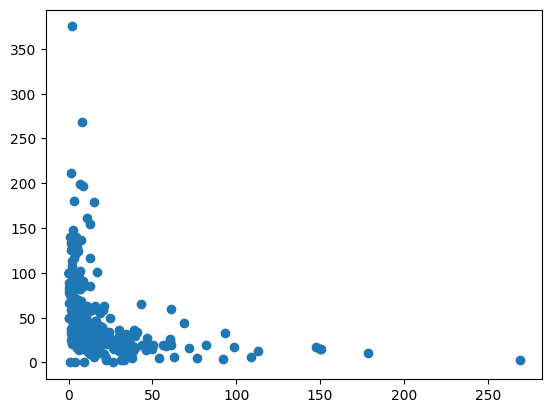

In [106]:

plt.scatter(mape_per_area_df.num_of_rides, mape_per_area_df.percent_error)

Text(0, 0.5, 'Residual')

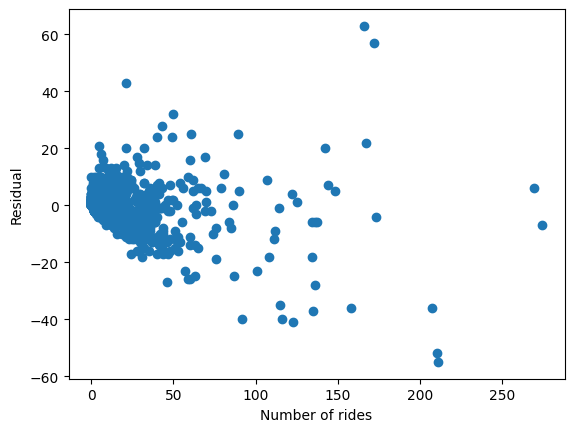

In [107]:
plt.scatter(eval_df.num_of_rides, eval_df.residuals)
plt.xlabel('Number of rides')
plt.ylabel('Residual')

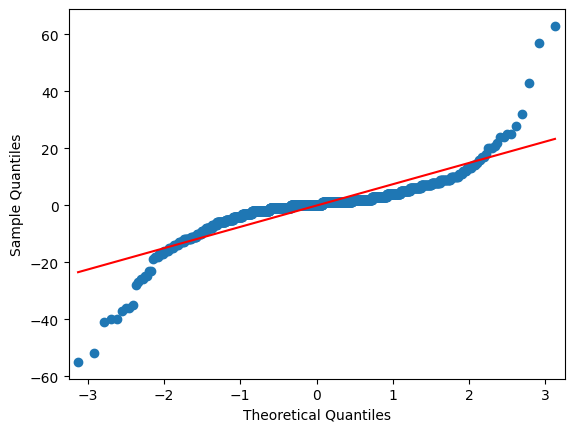

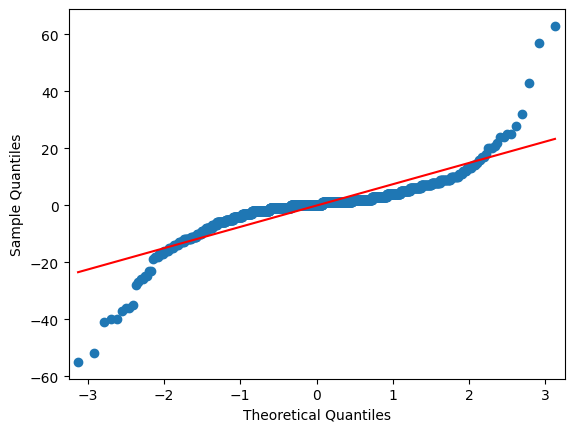

In [108]:
import statsmodels.api as sm

sm.qqplot(eval_df.residuals, line='s') 


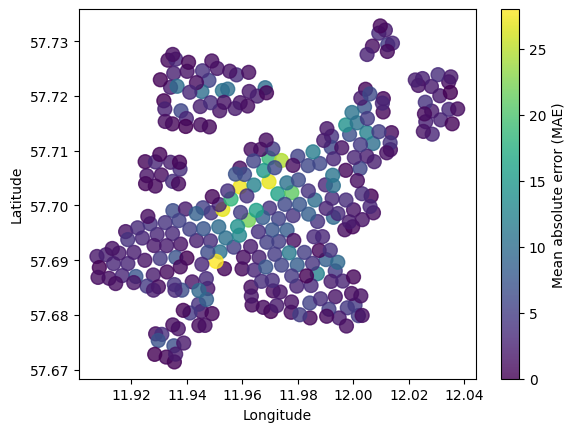

In [111]:

latitude = np.array(mape_per_area_df.start_lat)
longitude = np.array(mape_per_area_df.start_lon)
mae = np.array(mape_per_area_df.mae)

plt.scatter(longitude, latitude, c=mae, cmap='viridis', s=100, alpha=0.8)

# Adding colorbar for better interpretation of numbers
cbar = plt.colorbar()
cbar.set_label('Mean absolute error (MAE)')

# Adding labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
#plt.title('Number of rides based on latitude and longitude of start location')

plt.savefig('../notebooks/figures/num_of_rides_overview_per_h3index_small.png')


In [55]:
test_evaulation_df[test_evaulation_df.residuals < -40]

,num_of_rides,prediction,prediction_int,residuals
2841,210.0,157.756500,158.0,-52.0
2834,211.0,155.721115,156.0,-55.0
4641,123.0,81.874474,82.0,-41.0


,precipitation,start_weekday,max_temperature,avg_num_rides_in_area_one_week_before,num_of_rides
2866,0.0,Monday,28.7,27.428571,23.0
6248,0.0,Sunday,28.0,2.142857,2.0
2292,0.0,Thursday,27.1,11.428571,14.0
9277,0.0,Saturday,28.5,58.285714,61.0
8467,0.0,Saturday,28.5,7.428571,8.0
...,...,...,...,...,...
6172,0.0,Sunday,18.6,0.142857,0.0
4511,0.0,Wednesday,25.6,44.857143,51.0
763,0.0,Friday,27.3,4.285714,5.0
4977,0.1,Friday,17.8,0.857143,3.0


<Axes: >

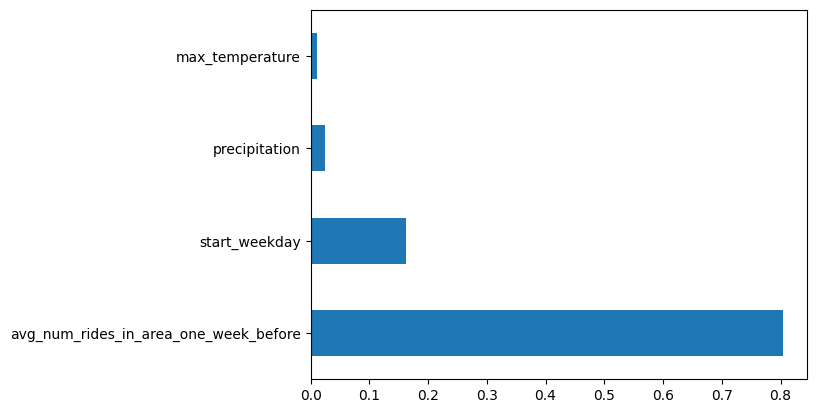

In [44]:
feature_importances = pd.Series(model.feature_importances_, index=list(X.columns))
feature_importances.nlargest(10).plot(kind='barh')